In [ ]:
import xarray as xr
from xhistogram.xarray import histogram
import gfdl_utils as gu
import gsw
import glob
import xesmf as xe
import numpy as np
from dask.diagnostics import ProgressBar

In [82]:
pathDict = {'pp':('/archive/Raphael.Dussin/'+
                  'FMS2019.01.03_devgfdl_20210706/'+
                  'CM4_piControl_c192_OM4p125_v6_alt1/'+
                  'gfdl.ncrc4-intel18-prod-openmp/pp'),
           'ppname':'ocean_annual_z_d2'
           'out':'ts',
           'local':'annual/10yr',
           'time':'0191-0200'}

variables = ['agessc','volcello','so','thetao']
ds = xr.Dataset()
for variable in variables:
    pathDict['add']=variable
    tmp = gu.core.open_frompp(**pathDict)
    ds = xr.merge([ds,tmp])


In [ ]:
def calc_hist_sigma2agessc(pathagessc, pathvolcello, pathso, paththetao, gridsame=False, **gridfiles):
    

In [89]:
# Age tracer
pathDict['ppname'] = 'ocean_annual_z_d2'
pathDict['add'] = 'agessc'
ds_agessc = gu.core.open_frompp(**pathDict)
pathDict['add'] = 'volcello'
ds_volcello = gu.core.open_frompp(**pathDict)
# Merge
ds_d2 = xr.merge([ds_agessc,ds_volcello])
# Grid
grid_d2 = xr.open_dataset(gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname']))

# T and S
pathDict['ppname'] = 'ocean_annual_z'
pathDict['add'] = 'so'
ds_so = gu.core.open_frompp(**pathDict)
pathDict['add'] = 'thetao'
ds_thetao = gu.core.open_frompp(**pathDict)
# Merge
ds_ts = xr.merge([ds_so,ds_thetao])
# Grid
grid = xr.open_dataset(gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname']))

In [ ]:
# Regrid to d2 grid
print('Define regrid')
renames = {'geolon':'lon','geolat':'lat'}
regridder = xe.Regridder(grid.rename(**renames), grid_d2.rename(**renames), "bilinear")

In [90]:
print('Perform regrid')
ds_out = regridder(ds_ts)
# Merge with d2 variables and chunk in time
ds = xr.merge([ds_d2,ds_out]).chunk({'time':1})

Perform regrid


In [91]:
# Calculate density
ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])

In [94]:
bins_sigma2 = np.arange(28,38,0.1)
bins_agessc = np.arange(0,200,1)
hs = histogram(ds['sigma2'],ds['agessc'],bins=[bins_sigma2,bins_agessc],dim=['xh','yh','z_l'],weights=ds['volcello'],block_size=len(ds['time']))

In [95]:
with ProgressBar():
    hs = hs.load()

[########################################] | 100% Completed |  3min 36.8s


In [99]:
hs_norm = hs/hs.sum('sigma2_bin')

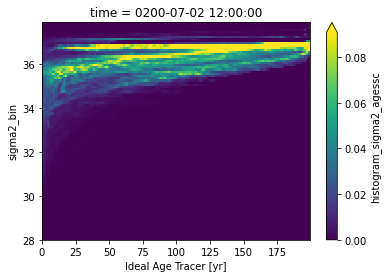

In [106]:
hs_norm.isel(time=-1).plot()

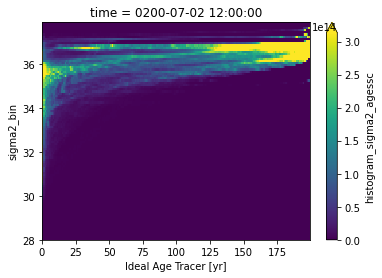

In [102]:
hs.isel(time=-1).plot(robust=True)